# 图片预处理

In [1]:
import os, shutil, platform
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from random import shuffle 

%matplotlib inline 

## 工具函数:判断操作系统种类

In [2]:
print("当前工作目录是:")
print(os.getcwd())

当前工作目录是:
/home/ubuntu/cat_vs_dog_cnn


In [3]:
from PIL import Image
print(Image.__file__)

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/PIL/Image.py


In [4]:
def is_Windows_OS():
    if platform.system() == 'Windows':
        return True
    else:
        return False

## 定义的目录结构变量

In [5]:
# 训练集图片从zip包解压之后存放的目录
train_images_folder = 'train'

# 训练集图片目录
train_set_folder = 'train1'
train_set_folder_cat = 'train1/cats/'
train_set_folder_dog = 'train1/dogs/'

# 验证集图片目录
validation_set_folder = 'valid'
validation_set_folder_cat = 'valid/cats/'
validation_set_folder_dog = 'valid/dogs/'

## 新建有关目录结构

In [6]:
def rmrf_mkdir(dirname):
    if os.path.exists(dirname):
        shutil.rmtree(dirname)
    os.mkdir(dirname)

rmrf_mkdir(train_set_folder)
os.mkdir(train_set_folder_cat)
os.mkdir(train_set_folder_dog)

rmrf_mkdir(validation_set_folder)
os.mkdir(validation_set_folder_cat)
os.mkdir(validation_set_folder_dog)

## 加载训练集目录

In [7]:
train_filenames = os.listdir(train_images_folder)
train_cat = filter(lambda x:x[:3] == 'cat', train_filenames)
train_dog = filter(lambda x:x[:3] == 'dog', train_filenames)

In [8]:
print (type(train_cat))
print (len(train_filenames))

<class 'filter'>
25000


In [9]:
print (train_filenames[24999])

cat.2814.jpg


定义一组移动有用的函数：

In [10]:
num_of_images_valid_set = 2500
        
def move_cat_images():
    timer = 0
    for filename in train_cat:
        if timer < num_of_images_valid_set:
            shutil.copy2('train/'+filename, validation_set_folder_cat)
        else:
            shutil.copy2('train/'+filename, train_set_folder_cat)
        timer = timer + 1

def move_dog_images():
    timer = 0
    for filename in train_dog:
        if timer < num_of_images_valid_set:
            shutil.copy2('train/'+filename, validation_set_folder_dog)
        else:
            shutil.copy2('train/'+filename, train_set_folder_dog)
        timer = timer + 1  

In [11]:
def fill_train_set_valid_set_folder_with_images():
    move_cat_images()
    move_dog_images()

In [12]:
fill_train_set_valid_set_folder_with_images()
print ('fill_train_set_valid_set_folder_with_images执行完毕')

fill_train_set_valid_set_folder_with_images执行完毕


# 搭建并且编译模型

In [19]:
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.layers import Dropout
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator

In [20]:
batch_size = 64
target_size = (299, 299)

# 不包含原有模型的全连接层
base_model = InceptionResNetV2(include_top=False, 
                             weights='imagenet',
                             input_shape = (299, 299, 3),
                             pooling='avg')

x = base_model.output

x = Dense(units = 1024, activation = 'relu',  name='fc1')(x)

x = Dropout(0.5, name='dropout')(x)

# Classifier
predictions = Dense(units = 1, activation='sigmoid',  name='predictions')(x)

model = Model(inputs=base_model.input, outputs=predictions)

print("模型组装完毕！")

模型组装完毕！


## 可视化模型结构

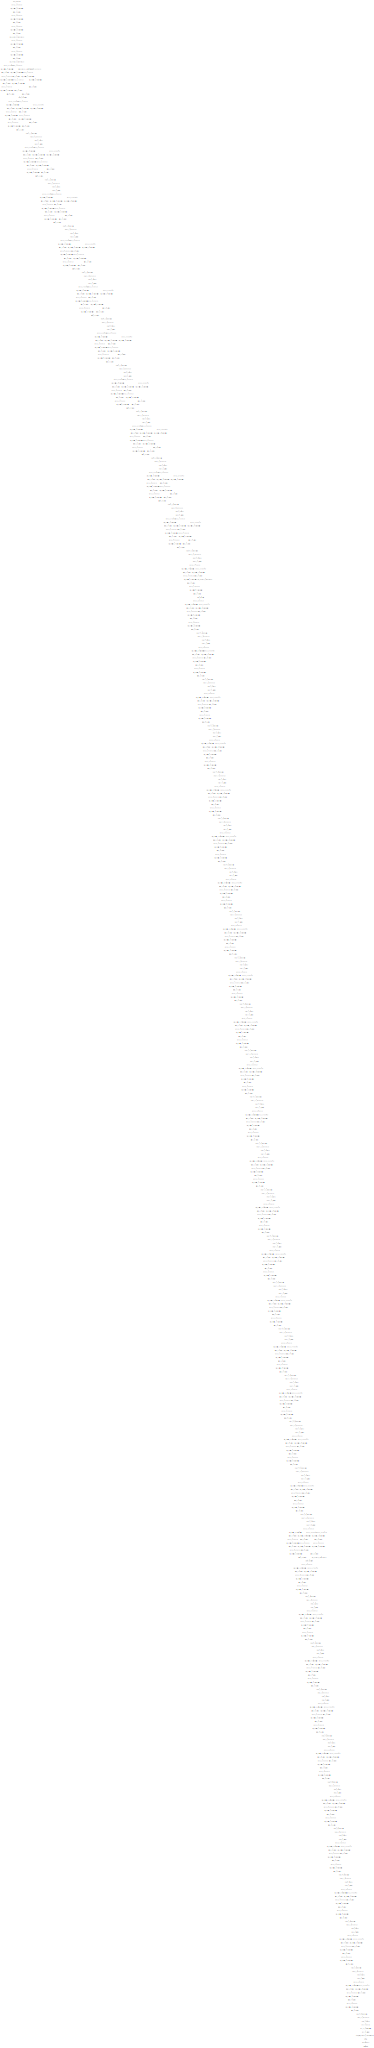

In [21]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(model).create(prog='dot', format='svg'))

## 打印各层名称

In [22]:
for i in range(len(model.layers)):
    print(i,model.layers[i].name)

0 input_2
1 conv2d_204
2 batch_normalization_204
3 activation_204
4 conv2d_205
5 batch_normalization_205
6 activation_205
7 conv2d_206
8 batch_normalization_206
9 activation_206
10 max_pooling2d_5
11 conv2d_207
12 batch_normalization_207
13 activation_207
14 conv2d_208
15 batch_normalization_208
16 activation_208
17 max_pooling2d_6
18 conv2d_212
19 batch_normalization_212
20 activation_212
21 conv2d_210
22 conv2d_213
23 batch_normalization_210
24 batch_normalization_213
25 activation_210
26 activation_213
27 average_pooling2d_2
28 conv2d_209
29 conv2d_211
30 conv2d_214
31 conv2d_215
32 batch_normalization_209
33 batch_normalization_211
34 batch_normalization_214
35 batch_normalization_215
36 activation_209
37 activation_211
38 activation_214
39 activation_215
40 mixed_5b
41 conv2d_219
42 batch_normalization_219
43 activation_219
44 conv2d_217
45 conv2d_220
46 batch_normalization_217
47 batch_normalization_220
48 activation_217
49 activation_220
50 conv2d_216
51 conv2d_218
52 conv2d_221

## 编译模型

In [27]:
for layer in model.layers[:632]:
    layer.trainable = False
    
for layer in model.layers[632:]:
    layer.trainable = True

# Compiling the CNN
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
print("模型编译完成!")

模型编译完成!


## 训练模型

In [28]:
train_image_gen = ImageDataGenerator(rotation_range=20,
                                     width_shift_range=0.2,
                                     height_shift_range=0.2,
                                     rescale = 1./255,
                                     shear_range = 0.2,
                                     zoom_range = 0.2,
                                     horizontal_flip = True)
print("训练集图片:")
training_set = train_image_gen.flow_from_directory('train1',
                                                 target_size = target_size,
                                                 batch_size = batch_size,
                                                 color_mode="rgb",
                                                 class_mode = 'binary')

valid_image_gen = ImageDataGenerator(rotation_range=20,
                                     width_shift_range=0.2,
                                     height_shift_range=0.2,
                                     rescale = 1./255,
                                     shear_range = 0.2,
                                     zoom_range = 0.2,
                                     horizontal_flip = True)
print("验证集图片:")
validation_set = valid_image_gen.flow_from_directory('valid',
                                                 target_size = target_size,
                                                 batch_size = batch_size,
                                                 color_mode="rgb",
                                                 class_mode = 'binary')


训练集图片:
Found 20000 images belonging to 2 classes.
验证集图片:
Found 5000 images belonging to 2 classes.


## 开始训练模型

In [29]:
# 训练集图片总量
train_size = 22000

# 每一轮训练需要执行的步长
steps_per_epoch = train_size/batch_size

# 验证集图片总量
valid_size = 3000
# 每一轮验证需要执行的步长
validation_steps = valid_size/batch_size

# 增加检查点，设置模型早停
callbacks = [EarlyStopping(monitor='val_loss', patience=5 ),
             ModelCheckpoint(filepath='final_model_weights.h5', monitor='val_loss', save_best_only=True)]

# 使用模型拟合图片数据
model.fit_generator(training_set, epochs = 10, steps_per_epoch = steps_per_epoch, callbacks=callbacks,
                    validation_data=validation_set, validation_steps = validation_steps)

Epoch 1/10
344/343 [==============================] - 601s 2s/step - loss: 0.0604 - acc: 0.9756 - val_loss: 0.0272 - val_acc: 0.9938
Epoch 2/10
344/343 [==============================] - 580s 2s/step - loss: 0.0364 - acc: 0.9866 - val_loss: 0.0177 - val_acc: 0.9934
Epoch 3/10
344/343 [==============================] - 545s 2s/step - loss: 0.0291 - acc: 0.9893 - val_loss: 0.0278 - val_acc: 0.9916
Epoch 4/10
344/343 [==============================] - 550s 2s/step - loss: 0.0293 - acc: 0.9893 - val_loss: 0.0470 - val_acc: 0.9882
Epoch 5/10
 45/343 [==>...........................] - ETA: 5:08 - loss: 0.0240 - acc: 0.9927

KeyboardInterrupt: 

## 开始预测

In [30]:
# 测试集图片从zip包解压缩之后的存放目录
test_set_folder = 'test'
test_folder ="test1"
test_inner_folder = "test1/test"
rmrf_mkdir(test_folder)
os.mkdir(test_inner_folder)

In [31]:
def move_test_images():
    test_filenames = os.listdir(test_set_folder)
    for filename in test_filenames:
        shutil.copy2( test_set_folder + '/' + filename, test_inner_folder)


In [32]:
move_test_images()
print("开始导入测试集图片:")
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(test_folder,
                                                  target_size=target_size, 
                                                  batch_size=batch_size,
                                                  shuffle = False, class_mode=None)

print("测试目录准备完成！")

开始导入测试集图片:
Found 12500 images belonging to 1 classes.
测试目录准备完成！


## 备份模型到`json`文件

In [33]:
from keras.models import model_from_json

# 保存模型结构
model_json = model.to_json()
with open("best_model.json", "w") as json_file:
    json_file.write(model_json)
    
print("模型已经保存到json文件！")

模型已经保存到json文件！


# 加载模型结构和权重

In [34]:
# 使用新的模型结构加载模型权重
json_file = open("best_model.json", "r")
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
print("loaded_model重新加载模型权重！")
loaded_model.load_weights('final_model_weights.h5')
print("loaded_model重新加载模型权重完成！")

loaded_model重新加载模型权重！
loaded_model重新加载模型权重完成！


In [ ]:
print("预测执行开始！")
pred_result = loaded_model.predict_generator(test_generator, verbose=1)
print("预测执行完毕！")

预测执行开始！
195/196 [============================>.] - ETA: 0s

In [ ]:
test_generator.filenames[:10]

In [ ]:
pred_result[:10]

## 导出预测结果

In [ ]:
import pandas as pd
from keras.preprocessing.image import *

solution = pd.read_csv("sample_submission.csv")

for i, fname in enumerate(test_generator.filenames):
        index = int(fname[fname.rfind('/')+1:fname.rfind('.')])
        solution.set_value(index-1, 'label', pred_result[i])

print("导出结果完成！")

In [ ]:
solution.to_csv("pred-18.csv", index = False)
solution.head(10)